# Lab 7: Optimization and learning
**Theo Puranen Åhfeldt**

# **Abstract**

In this report Newton's method and the gradient descent method for solving the local minimization problem in $R^n$ are implemented. The implementations are tested by comparing their outputs with the exact solution for a set of model problems. The results indicate that both implementations are succesful.

# **Set up environment**

To have access to the neccessary modules you have to run this cell.

In [1]:
# Load neccessary modules.
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# **Introduction**

Given a function $f:D \to R$ where $D \subset R^n$ we can define the minimization problem as finding the point $x^* \in D$ such that 

$$f(x^*) \leq f(x),\quad \forall x \in D$$

By solving the minimization problem we can optimize any model as long as we can define a cost function $f$ for which minimization represents optimization of the model. However, it is often hard to find such a global minimum so instead we will look at methods solving the similar problem of finding a local minimum $\hat{x} \in D$ such that 

$$f(\hat{x}) \leq f(x),\quad \forall x: \lVert x - \hat{x} \rVert < \epsilon$$

for some $\epsilon > 0$. By Fermat's theorem such points $\hat{x}$ (that are not on the boundary) must be critical points, that is $\nabla f(\hat{x}) = 0$. 

# **Method**

Newton's method and the gradient descent method are implemented directly after the mathematically defined step equation. The methods require the gradient and hessian which are approximated using finite difference. We test the implementations by comparing the outputs with the exact solution for a set of model problems.

## Gradient descent method in Rn

Given a function $f: R^n \to R$ the gradient is defined as

$$\nabla f = \left(\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1}, \dots, \frac{\partial f}{\partial x_n}\right)^T$$

In order to compute the gradient for arbitrary scalar functions we will use finite difference as an approximation.

In [2]:
def gradient(f, x, h=1e-8):
    return np.array([(f(x + dx) - f(x))/h for dx in h * np.identity(x.size)])

The gradient points in the direction of steepest ascent, so in order to decrease the function $f$ we can move a step $\alpha$ in the direction of the negative gradient. This gives us the step equation:

$$x^{(k+1)} = x^{(k)} -\alpha^{(k)}\nabla f(x^{(k)})$$

Each step will bring us closer to the local minimum, and it will have been found when $\nabla f(x^{(k)}) = 0$. However, it might take forever to find the exact solution, so instead we stop iterating when we get sufficiently close  as determined by the condition that $\lVert\nabla f(x^{(k)})\rVert < \mathrm{TOL}$.

For simplicities sake we will use a constant step length. We also add an optional parameter `test` for getting all the intermediate values for testing purposes.

In [3]:
def gradient_descent(f, x0, TOL=1e-8, step=1, test=False):
    xs = [x0]
    x = x0
    df = gradient(f, x)
    while np.linalg.norm(df) > TOL:
        df = gradient(f, x)
        x = x - step*df
        xs.append(x)
    if test:
        return xs
    else:
        return x

## Newton's method in Rn

For Newton's method we need to compute the hessian. Once again we will use finite difference for a general approximation. We use the fact that the hessian is the jacobian of the gradient and reuse those functions for a concise implementation.

In [4]:
def jacobian(f, x, h=1e-8):
    return np.array([(f(x + dx) - f(x))/h for dx in h * np.identity(x.size)]).transpose()

def hessian(f, x, h=1e-5):
    grad = lambda y: gradient(f, y, h)
    return jacobian(grad, x, h)

Newton's method is based on approximation of the function using the Taylor's expansion of second degree. The step equation is derived from setting the gradient of the approximation to 0 and it looks like this:

$$x^{(k+1)} = x^{(k)} + \Delta x^{(k)}$$

where

$$\Delta x^{(k)} = -(Hf(x^{(k)}))^{-1}\nabla f(x^{(k)})$$

For our implementation we will calculate $\Delta x^{(k)}$ by solving the equation $(Hf(x^{(k)})) \Delta x^{(k)} = -\nabla f(x^{(k)})$ instead of calculating the inverse hessian directly.

In [5]:
def newtons_method(f, x0, TOL=1e-8, test=False):
    xs = [x0]
    x = x0
    df = gradient(f, x)
    while np.linalg.norm(df) > TOL:
        df = gradient(f, x)
        x = x + np.linalg.solve(hessian(f, x), -df)
        xs.append(x)
    if test:
        return xs
    else:
        return x

## Tests

To test the minimization algorithms we will use the following functions:

In [6]:
test_fun1 = lambda x: np.cos(x[0]) + np.sin(x[1])
min1, min2 = np.array([np.pi, -np.pi/2]), np.array([-np.pi, 3*np.pi/2])

test_fun2 = lambda x: 2*x[0]**2 + x[1]**2
min3 = np.zeros((2,))

We know that `test_fun1` has infinitely many local minima, two of which are $(\pi, -\pi/2)$ and $(-\pi, 3\pi/2)$ and `test_fun2` has only one minimum $(0,0)$. To test the implementations, we run them with the testing parameter set to true and plot the distance to the exact solution for each iteration with respect to the $L^2$ norm.

In [7]:
def test(f, sol, x0, step):
    grad_errors = [np.linalg.norm(x - sol) for x in gradient_descent(f, x0, step=step, test=True)]
    newt_errors = [np.linalg.norm(x - sol) for x in newtons_method(f, x0, test=True)]
    plt.plot(grad_errors, label="gradient descent")
    plt.plot(newt_errors, label="newton's")
    plt.legend()
    plt.show()

# **Results**

This section shows the results of the tests as defined in the previous section.

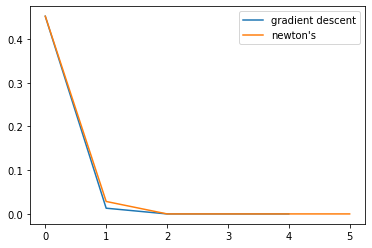

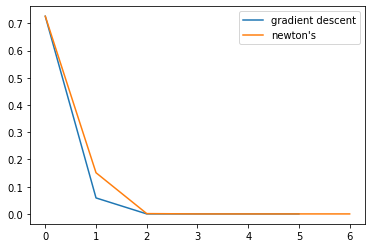

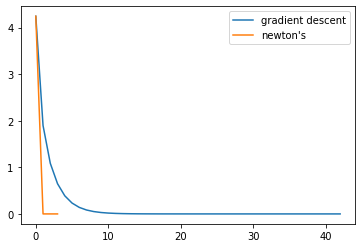

In [8]:
test(test_fun1, min1, np.array([3, -2]), 1)
test(test_fun1, min2, np.array([-3, 4]), 1)
test(test_fun2, min3, np.array([3, 3]), 0.4)

# **Discussion**

The implementations for both methods converge to the exact solution indicating that they are correct. For the first test function, gradient descent converges slightly faster with a large step size of 1. However, for the second test function I had to choose a smaller step size or it would diverge. With the smaller step size, gradient descent converges much slower than Newton's method. This highlights the importance of choosing the step size wisely for gradient descent to work well. Choosing it dynamically using something like a line search would probably yield better results.